 SVMs are very powerful, and until not too long ago were considered state-of-the-art, but recently they have been relegated by neural networks and deep learning.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

As our data set, we use bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campaign. The target y is binary and indicates whether the client signed up for a term deposit or not.

In [4]:
bank = pd.read_csv('bank-full.csv', sep = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Let's look at the scatter plot of the numeric columns in the data.

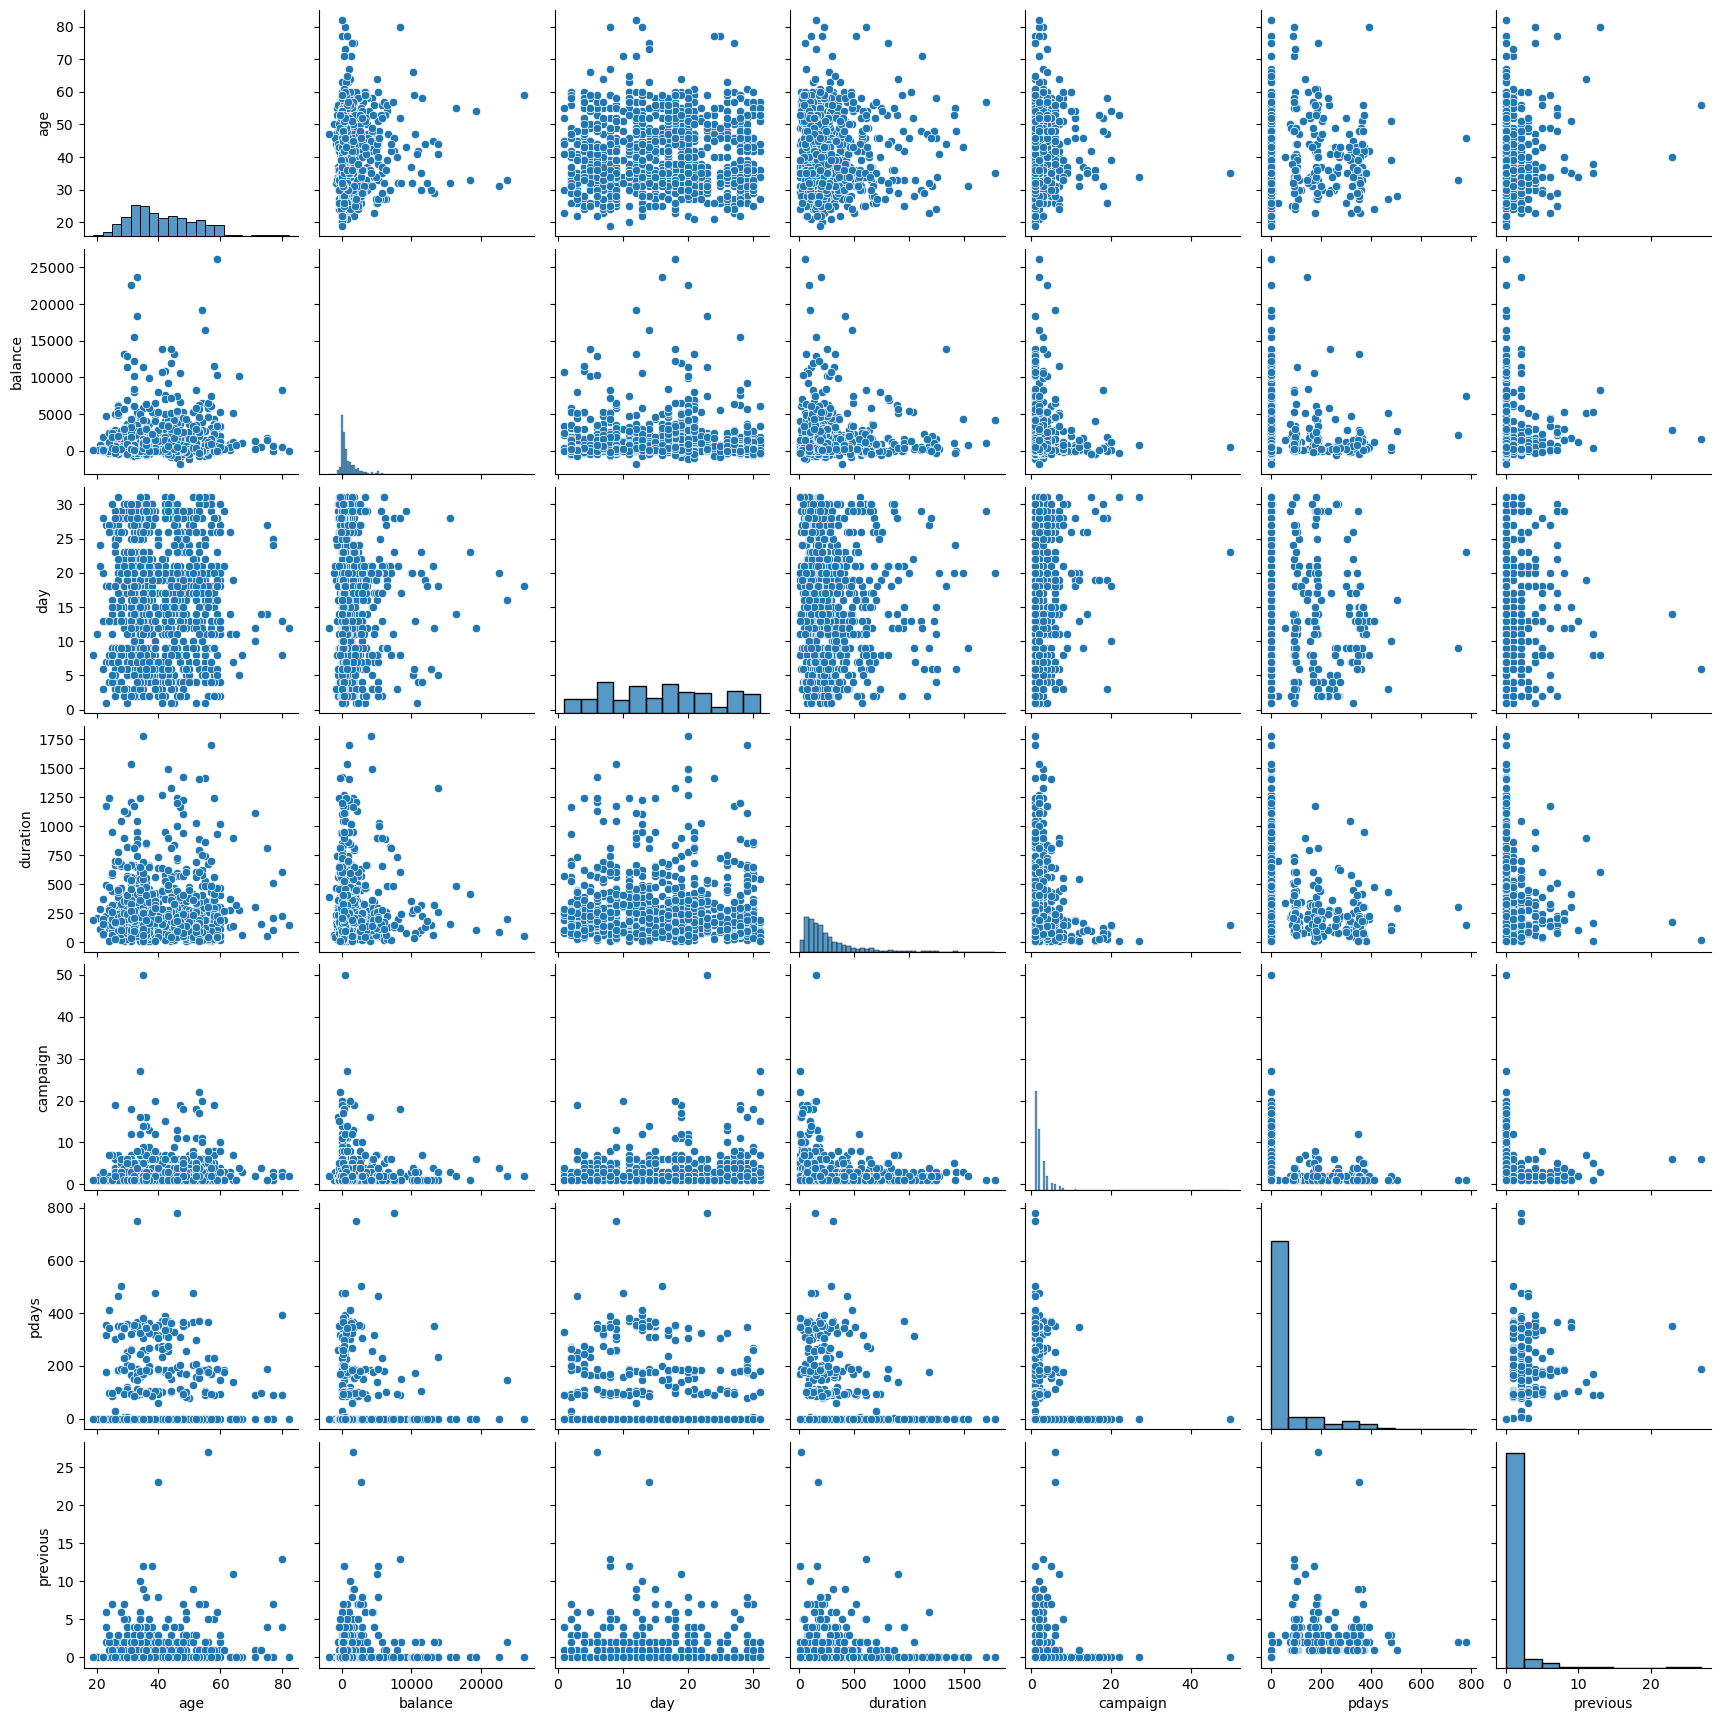

In [5]:
sns.pairplot(bank.sample(1000));

Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [7]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print("Numeric columns are {}.".format(", ".join(num_cols)))
print("Categorical columns are {}.".format(", ".join(cat_cols)))

Numeric columns are age, balance, day, duration, campaign, pdays, previous.
Categorical columns are job, marital, education, default, housing, loan, contact, month, poutcome.


We now need to split the data. SVMs can need a lot of tuning, so let's talk about splitting strategies. If we wanted to do our hyper-parameter tuning manually, then we would do a three-way split:

the training data is used to train the model
the validation data is used for model selection, i.e. to evaluate each model as we try different hyper-parameter combinations and select the best model, which we call the final model
the test data is used to evaluate the final model so we have an unbiased estimate of its performance
To perform the three-way split, we first split the data into training and test data, and then further split the training data into training and validation.

However, using sklearn there's another way that we can tune our hyper-parameters using only a two-way split and cross-validation (we explain this later in the notebook):

the training data is used to both to train many models and select the best, i.e. the training data is both the training data and the validation data
the test data is used to evaluate the final model so we have an unbiased estimate of its performance
As we will see later, sklearn will handle a lot of the complexity for us, so we don't have to write our own code to do the model training and selection. So let's split the data into training and test data:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.10, random_state = 42)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

print("Training data has {} rows.".format(X_train.shape[0]))
print("Test data has {} rows.".format(X_test.shape[0]))

Training data has 40689 rows.
Test data has 4522 rows.


Now we can start pre-processing the data. We begin by one-hot-encoding our categorical features.

In [9]:
onehoter = OneHotEncoder(sparse_output = False)
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names_out(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

X_train_onehot.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Next we normalize our numeric features. It's important to normalize features when training an SVM algorithm.

In [10]:
znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)

X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,-1.124112,-0.443322,-0.099012,0.231962,0.076064,-0.411045,-0.249556
1,1.510135,-0.314600,-0.459566,-0.581586,-0.244890,-0.411045,-0.249556
2,1.227894,-0.211233,-1.300857,-0.126155,-0.565844,-0.411045,-0.249556
3,1.039734,0.230193,-0.699935,-0.130048,-0.565844,-0.411045,-0.249556
4,-0.653711,0.134627,-1.421042,0.391557,-0.565844,1.216026,0.615550


In [11]:
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 40689 rows and 51 columns.
Featurized test data has 4522 rows and 51 columns.


Before we begin training with SVMs, recall that SVMs are very compute heavy and may require a lot of tuning. While we do all this in search of the best model, it's worthwhile having a baseline against which we can compare performance. So we first train a logistic regression model and evaluate it. We chose logistic regression because it is efficient and does a good job even without much tuning.

In [15]:
logit = LogisticRegression(max_iter = 5000, solver = 'lbfgs')
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Because the problem is one of binary classification, we will evaluate each model by looking at precision and recall.

In [13]:
precision_train = precision_score(y_train, y_hat_train, pos_label = 'yes') * 100
precision_test = precision_score(y_test, y_hat_test, pos_label = 'yes') * 100

recall_train = recall_score(y_train, y_hat_train, pos_label = 'yes') * 100
recall_test = recall_score(y_test, y_hat_test, pos_label = 'yes') * 100

print("Precision = {:.0f}% and recall = {:.0f}% on the training data.".format(precision_train, recall_train))
print("Precision = {:.0f}% and recall = {:.0f}% on the validation data.".format(precision_test, recall_test))

Precision = 65% and recall = 35% on the training data.
Precision = 63% and recall = 34% on the validation data.


We can see that as expected precision and recall are slightly worse on the validation data than the training data, but not by enough that we should be worried about overfitting. So no need to tune the logistic regression model. We will take it as-is and use its performance as the baseline performance.